# Evaluate the Single-Linkage Ascendant Hierarchical Clustering

Here we assess the potential of the clustering algorithm CAH single-linkage for the clustering of the images, with an example on curved rows, where DBSCAN fails sometimes.

Results : we could abandon this clustering for three reasons
1. The clustering results are not better with this method compared with DBSCAN for example
2. We have to give the number of cluster a priori (or alternatively a distance threshold)
3. The execution is prohibitive (200 sec for half and image).

In [1]:
import imageio
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
import time

from skimage.morphology import skeletonize, binary_dilation, binary_erosion, binary_closing
from skimage import data
from skimage.util import invert

from sklearn.cluster import AgglomerativeClustering


Imported image, expected number of clusters : 18


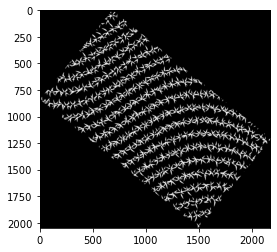

In [2]:
path = "D:/Documents/IODAA/Fil Rouge/Resultats/dIP_vs_dIR_curved/densite=7/027_54_analysis/Output/Session_1/Otsu_R/OTSU_R_027_054_3_300.jpg"
save_img_path = "D:/Documents/IODAA/Fil Rouge/Resultats/dIP_vs_dIR_curved/densite=7/Analysis/027_024_CAH1.svg"

image = imageio.imread(path)
plt.imshow(image)
nb_clusters = 18
print(f"Imported image, expected number of clusters : {nb_clusters}")

In [5]:
def threshold(img, threshold=127):
    ar = np.ones(img.shape)
    for i in range(ar.shape[0]):
        for j in range(ar.shape[1]):
            # for k in range(array.shape[2]):
            if img[i, j] < threshold:
                ar[i, j] = 0
    return ar

In [31]:
subsample = 100000
n_clusters = 18
array = threshold(np.asarray(image[:, :, 1]))
positive_pixels = np.argwhere(array == 1)
positive_pixels = positive_pixels[:subsample]

In [32]:
print(positive_pixels.shape)

(100000, 2)


In [52]:
t0 = time.time()
model = AgglomerativeClustering(linkage="single",
                                distance_threshold=10,
                                n_clusters=None)
model.fit(positive_pixels)
elapsed_time = time.time() - t0

23


Text(0.5, 0.98, 'cluster number: 18')

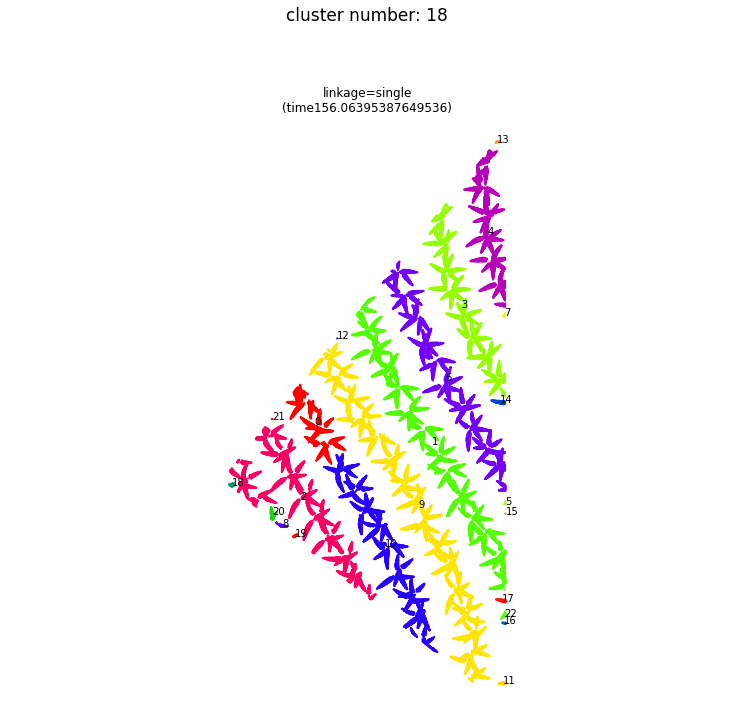

In [53]:
txts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# cluster labels
for i in set(model.labels_):
    xtext = np.median(positive_pixels[model.labels_ == i, 0])
    ytext = np.median(positive_pixels[model.labels_ == i, 1])
    txt = ax.text(xtext, ytext, str(i))
    # txt.set_path_effects(
    #    [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
    # )
    txts.append(txt)

print(len(set(model.labels_)))

# n_cluster = 2

# # text
# xtext = np.median(positive_pixels[model.labels_ == n_cluster, 0])
# ytext = np.median(positive_pixels[model.labels_ == n_cluster, 1])
# txt = ax.text(xtext, ytext, str(n_cluster))

# plot
ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_, cmap="prism")
# ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_ * 10, cmap="Pastel1")
plt.title(f'linkage=single\n(time{elapsed_time})',
        fontdict=dict(verticalalignment='top'))
plt.axis('equal')
plt.axis('off')

plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                left=0, right=1)
# plt.suptitle(f'n_cluster={n_clusters}', size=17)
plt.suptitle(f"cluster number: {n_clusters}", size=17)

# save
# plt.savefig(save_img_path)

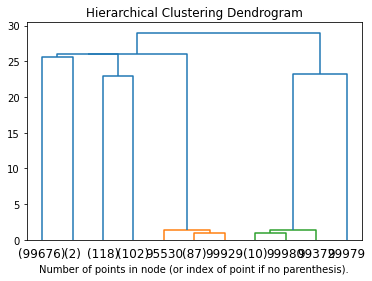

In [46]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()